In [3]:
import sys
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [2]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
tqdm.pandas()
from time import time

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [18]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')


with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [19]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


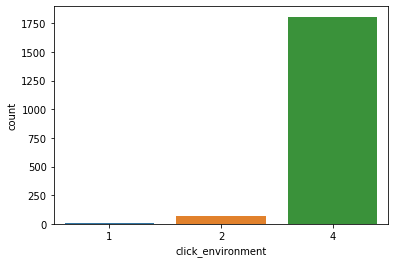

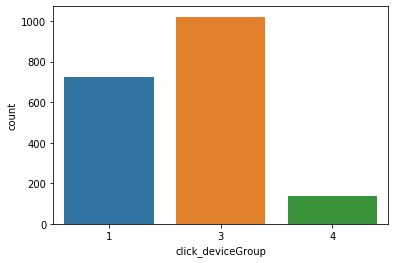

In [6]:
sns.countplot(clicks_sample.click_environment)
plt.show()
sns.countplot(clicks_sample.click_deviceGroup)
plt.show()

In [14]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id','click_environment','click_deviceGroup'] #validate with EDA
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [15]:
user_clicks = get_click_data()

In [18]:
display(user_clicks.head(),user_clicks.nunique())

,user_id,click_article_id
0,0,157541
1,0,68866
2,1,235840
3,1,96663
4,2,119592


user_id             322897
click_article_id     46033
dtype: int64

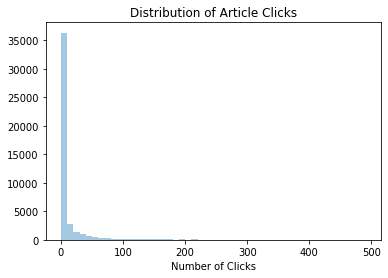

Min: 1
Max: 34145


In [9]:
sns.distplot(
    user_clicks.click_article_id.value_counts(),
    kde=False,
    bins=np.arange(0,500,10)
).set_title('Distribution of Article Clicks')
plt.xlabel('Number of Clicks')
plt.show()

print('Min:', user_clicks.click_article_id.value_counts().min())
print('Max:', user_clicks.click_article_id.value_counts().max())

Article clicks are skewed heavily left.

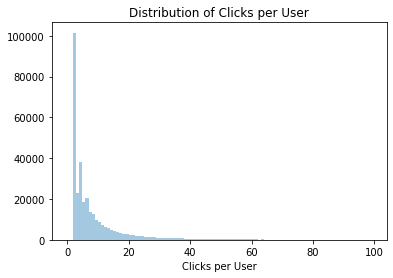

Min: 2
Max: 1048


In [10]:
sns.distplot(
    user_clicks.user_id.value_counts(),
    kde=False,
    bins = np.arange(0,100,1)
).set_title('Distribution of Clicks per User')
plt.xlabel('Clicks per User')
plt.show()

print('Min:', user_clicks.user_id.value_counts().min())
print('Max:', user_clicks.user_id.value_counts().max())

## To do
- figure out implicit rating system
- sample and train/test split
- models
    1. KNN
    2. Bucketed random projection (ANN)
        - https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/
        - https://eng.uber.com/lsh/
    3. User embeddings
    4. User embeddings with nonlinearity
        - use clustering to group interests


### User Embeddings
- Embeddings learned through SGNS maximize the dot-product between observed pairs and minimize it for random pairs.
- The dot product of embeddings of any given pair represents the likelihood of observing the pair together.
- If we are interested in learning an association between any two sets of entities, we can technically learn any kinds of embeddings through SGNS
- In our model, we will replace word pairs with reader - article pairs

In [16]:
#tools to use
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA

# Data Setup
- Filter out irrelevant columns
- Pick users whomst'd've read at least N articles

In [20]:
df = user_clicks.copy()

In [ ]:
sizes = [df.user_id.nunique()]

for i in tqdm(range(2, 21)): #might be able to code this in a faster way
    sizes.append(df[df.groupby('user_id').user_id.transform(len) > i].user_id.nunique())

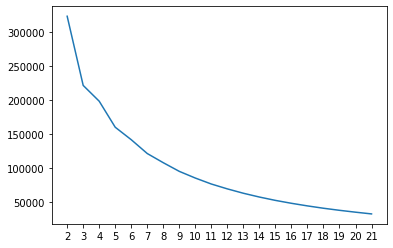

In [41]:
sns.lineplot(list(range(2,22)),sizes)
plt.xticks(range(2,22))
plt.show()

Might be a good idea to set N=10
Training set will have just 8 for each user, so there will be 2 or more to predict.

In [23]:
start = time()
df_ = df[df.groupby('user_id').user_id.transform(len) >= 10]
print(time()-start)

94.24544906616211


In [ ]:
df_['env_device'] = 'env:' + df_.click_environment.astype(str) + ' device:' + df_.click_deviceGroup.astype(str)
df_.drop(['click_environment','click_deviceGroup'],axis=1,inplace=True)

In [28]:
df_.head()

,user_id,click_article_id,env_device
2,1,235840,env:4 device:1
3,1,96663,env:4 device:1
6,3,236065,env:4 device:3
7,3,236294,env:4 device:3
10,5,168868,env:4 device:1


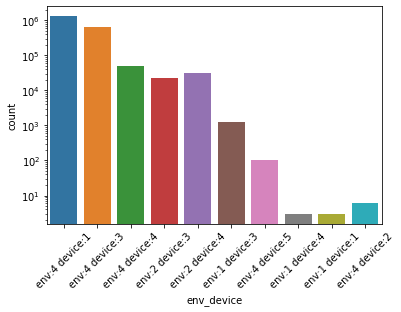

In [29]:
sns.countplot(df_.env_device)
plt.yscale('log')
plt.xticks(rotation=45)
plt.show()

#### Merge embeddings

In [241]:
df_ = df_.merge(
    pd.DataFrame(embeddings),
    how='left',
    left_on='click_article_id',
    right_index=True
)

10.697396039962769


In [244]:
df_.to_csv('data/user_embeddings.csv')

In [245]:
#read back
start = time()
df_ = pd.read_csv('data/user_embeddings.csv',index_col=0)
print(time()-start)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


99.77132892608643


In [246]:
df_.head()

,user_id,click_article_id,env_device,0,1,2,3,4,5,6,...,240,241,242,243,244,245,246,247,248,249
2,1,235840,env:4 device:1,-0.168369,-0.967274,0.226036,0.145089,-0.417114,-0.693828,-0.741834,...,-0.010313,-0.422416,0.372931,-0.540084,0.242361,0.616011,0.704936,0.571687,0.545211,0.650550
3,1,96663,env:4 device:1,-0.463952,-0.958577,-0.317925,0.143565,0.009962,0.510263,-0.703141,...,0.779381,0.505448,-0.262309,-0.442881,0.695514,0.748444,-0.209889,-0.231323,-0.082891,-0.203830
6,3,236065,env:4 device:3,-0.583720,-0.945301,-0.770678,-0.654855,-0.409393,-0.386152,-0.184850,...,-0.460681,-0.149449,0.158473,-0.431712,0.257235,-0.118843,-0.072126,-0.028298,0.327733,0.428365
7,3,236294,env:4 device:3,-0.791363,-0.967025,-0.247181,-0.462593,0.238766,-0.713218,-0.789062,...,-0.609091,0.230817,0.090354,-0.457567,-0.026513,-0.433131,0.347777,0.511057,0.470070,0.092472
10,5,168868,env:4 device:1,-0.566814,-0.969073,0.212298,-0.424613,-0.843768,0.529609,0.366083,...,0.023162,-0.634281,-0.334300,0.593486,-0.761024,0.364188,0.238170,0.681951,-0.501074,-0.115498


#### Split train and test

https://stackoverflow.com/questions/22472213/python-random-selection-per-group

In [247]:
start = time()
size = 8        # sample size per user
replace = False  # without replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
df_train = df_.groupby('user_id', as_index=False).apply(fn)
print(time()-start)

126.30983185768127


In [248]:
#takes 17 minutes

start = time()
df_test = df_[~df_.index.isin(df_train.index)]
print(time()-start)

1037.9082367420197


In [250]:
df_train.reset_index(drop=True,inplace=True)
df_test.reset_index(drop=True,inplace=True)

In [252]:
#takes 19 minutes

start = time()
df_train.to_csv('data/train.csv')
df_test.to_csv('data/test.csv')
print(time()-start)

1147.8053047657013


# Load Train and Test Data

In [4]:
start = time()
df_train = pd.read_csv('data/train.csv',index_col=0)
df_test = pd.read_csv('data/test.csv',index_col=0)
print(time()-start)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


131.4666609764099


In [5]:
print('train:', df_train.shape[0])
print('test:', df_test.shape[0])

train: 684502
test: 2029107


In [6]:
df_train.head()

,user_id,click_article_id,env_device,0,1,2,3,4,5,6,...,240,241,242,243,244,245,246,247,248,249
0,1,285719,env:4 device:1,-0.118549,-0.957376,-0.751805,-0.566605,-0.899491,-0.510777,0.510855,...,-0.274394,-0.054381,0.341704,-0.395201,0.378282,0.416298,-0.478623,0.912017,0.101685,0.660538
1,1,234481,env:4 device:1,-0.744894,-0.975940,-0.101474,-0.620068,0.516190,-0.695848,-0.850939,...,-0.327291,-0.009473,0.469663,-0.734911,-0.070421,-0.457637,0.518804,0.576141,0.763434,0.224886
2,1,235840,env:4 device:1,-0.168369,-0.967274,0.226036,0.145089,-0.417114,-0.693828,-0.741834,...,-0.010313,-0.422416,0.372931,-0.540084,0.242361,0.616011,0.704936,0.571687,0.545211,0.650550
3,1,283392,env:4 device:1,-0.248988,-0.976156,-0.069826,-0.692906,-0.695744,-0.703383,0.930634,...,0.224778,-0.870308,-0.753590,0.024811,0.536427,0.130145,-0.276387,0.464620,0.129086,0.382053
4,1,36162,env:4 device:1,0.394471,-0.954570,-0.126430,-0.031528,-0.202543,0.325258,-0.426356,...,0.121050,0.351851,-0.324864,-0.497410,0.602626,-0.189069,0.012937,0.401118,-0.050076,0.182424


In [255]:
# need to append unread articles to training set somehow...

# use embeddings data already provided

# Model 1: User Latent Vectors

## 1a: Generate Basic User Embeddings

In [9]:
start = time()
user_embeddings = df_train.drop(columns=['click_article_id','env_device'],axis=1).groupby('user_id').mean()
print(time()-start)

3.1720268726348877


In [10]:
user_embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
user_id,,,,,,,,,,,,,,,,,,,,,
1,-0.268243,-0.963677,-0.285129,-0.325967,-0.343103,-0.265541,-0.255980,0.023301,0.221150,-0.155244,...,-0.086365,-0.174222,-0.104718,-0.341327,0.248698,0.103690,-0.111106,0.281490,0.182084,0.346182
3,-0.524615,-0.962642,-0.308300,-0.318949,-0.041010,-0.378690,-0.481024,-0.120330,0.091089,-0.194023,...,-0.067039,-0.039297,0.080214,-0.538102,0.014051,0.160522,-0.043994,0.245872,0.480289,0.132180
5,-0.059178,-0.962682,0.113817,-0.133192,-0.259398,0.082888,-0.135339,0.003867,0.234593,-0.147918,...,-0.088267,-0.106871,-0.149357,0.090597,0.247770,-0.186963,0.229703,0.311521,0.101328,0.231018
6,-0.214457,-0.963717,-0.201584,0.142360,-0.494981,-0.360691,-0.478616,0.131421,0.023279,-0.023747,...,-0.042374,0.162305,0.027745,-0.377227,0.414735,0.287469,-0.328323,0.398101,-0.082419,0.103499
7,0.055987,-0.963339,-0.350364,-0.124132,-0.272336,-0.182814,-0.060221,0.197762,0.142060,0.104627,...,0.267406,-0.076521,-0.588011,-0.162770,0.336379,0.104249,-0.030370,-0.161626,0.349620,0.334192


## 1b: Optimize User Embeddings with SGD

Note that simultaneous optimization of user and item embeddings, _U_ and _V_, with MapReduce is ideal for scalability, but is unnecessary since we're starting with document vectors already.

- Maximize Dot Product of User Embedding with Relevant Articles
- Minimize Dot Product of User Embedding with Random Articles

In [20]:
embeddings.shape

(364047, 250)

In [14]:
def get_user_article_ids(u,df):
    return np.array(df.loc[df.user_id==u].click_article_id)

In [55]:
def get_random_V_d_bar(u,df,embeddings):
    #returns a random article embedding not chosen by given user (used for SGD)
    return embeddings[np.random.choice(
        np.delete(
            np.arange(embeddings.shape[0]),
            get_user_article_ids(u,df)
        )
    )]

In [46]:
get_user_article_ids(100,df_train)

array([237822, 124177, 140720, 331225, 166621, 332114, 108854, 337143])

In [54]:
get_random_V_d_bar(100,df_train,embeddings)[0:10]

array([ 0.2856203 , -0.960444  ,  0.43218547, -0.7208655 ,  0.02781178,
        0.05319243, -0.28404325, -0.5076617 ,  0.06404305,  0.12175658],
      dtype=float32)

In [11]:
df_train.head()

,user_id,click_article_id,env_device,0,1,2,3,4,5,6,...,240,241,242,243,244,245,246,247,248,249
0,1,285719,env:4 device:1,-0.118549,-0.957376,-0.751805,-0.566605,-0.899491,-0.510777,0.510855,...,-0.274394,-0.054381,0.341704,-0.395201,0.378282,0.416298,-0.478623,0.912017,0.101685,0.660538
1,1,234481,env:4 device:1,-0.744894,-0.975940,-0.101474,-0.620068,0.516190,-0.695848,-0.850939,...,-0.327291,-0.009473,0.469663,-0.734911,-0.070421,-0.457637,0.518804,0.576141,0.763434,0.224886
2,1,235840,env:4 device:1,-0.168369,-0.967274,0.226036,0.145089,-0.417114,-0.693828,-0.741834,...,-0.010313,-0.422416,0.372931,-0.540084,0.242361,0.616011,0.704936,0.571687,0.545211,0.650550
3,1,283392,env:4 device:1,-0.248988,-0.976156,-0.069826,-0.692906,-0.695744,-0.703383,0.930634,...,0.224778,-0.870308,-0.753590,0.024811,0.536427,0.130145,-0.276387,0.464620,0.129086,0.382053
4,1,36162,env:4 device:1,0.394471,-0.954570,-0.126430,-0.031528,-0.202543,0.325258,-0.426356,...,0.121050,0.351851,-0.324864,-0.497410,0.602626,-0.189069,0.012937,0.401118,-0.050076,0.182424


# TO DO
- you MUST keep the click article ids

In [ ]:
def 

In [172]:
df_train_reindex = df_train.set_index(['user_id',df_train.index])

In [167]:
df_train_reindex.head()

click_article_id      env_device
user_id                                   
1       0           285719  env:4 device:1
        1            59758  env:4 device:1
        2           283392  env:4 device:1
        3           160474  env:4 device:1
        4            36162  env:4 device:1

# Model 2: Multiple User Latent Vectors

### Part 0: Clustering The Corpus

In [11]:
def fit_kmeans(X,range_,ratio):
    distortions = []
    silhouettes = []
    for n_clusters in tqdm(range_):
        km = KMeans(
                n_clusters=n_clusters,
                init='k-means++',
                max_iter=300,
                algorithm='elkan',
                random_state=0,
            )
        
        sample = X[np.random.randint(
                    X.shape[0],
                    size=int(X.shape[0]*ratio)
                ), :]
        
        km.fit_predict(sample)
        
        distortions.append(
           km.inertia_
        )
        silhouettes.append(
            metrics.silhouette_score(sample, km.labels_)
        )
    #distortions
    plt.plot(range_, distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()
    #silhouettes
    plt.plot(range_, silhouettes, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.show()
    
def fit_hac(X,range_,ratio):
    for n_clusters in tqdm(range_):
        hac = AgglomerativeClustering(
            n_clusters=n_clusters,
            affinity='euclidean',
            linkage='single'
        ).fit(X)
        
        sample = X[np.random.randint(
                    X.shape[0],
                    size=int(X.shape[0]*ratio)
                ), :]
        
        hac.fit_predict(sample)

        plot_dendgrogram(hac)
    

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

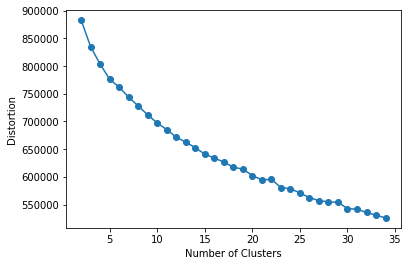

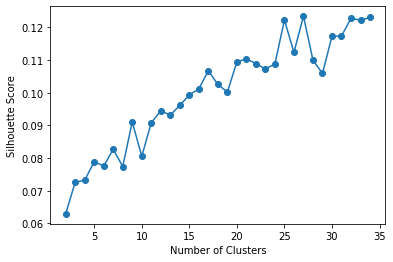

In [12]:
fit_kmeans(
    embeddings,
    range(2,35),
    0.05
)

#use elbow method to pick optimal number of clusters

### Part 1: User Interest Partition

In [ ]:
# https://www.altoros.com/blog/using-k-means-clustering-in-tensorflow/

### Part 2: Modeling

# Model 3: Nonlinear Latent Factorization with One-Pass Clustering
Article: https://www.researchgate.net/profile/Doreen_Cheng2/publication/266887747_Situation-aware_User_Interest_Mining_on_Mobile_Handheld_Devices/links/546e31b80cf2b5fc17606f8c.pdf

# Model 4: Hyperplane Separation

Generate User SVC weight matricies instead of embeddings

In [ ]:
# Tensorflow SVM Example:
import numpy
import tensorflow as tf

# X - (157, 128) - 157 sets of 128 features
# Y - (157) - classifications of the feature sets

X = numpy.zeros([157, 128])
Y = numpy.zeros([157], dtype=numpy.int32)
example_id = numpy.array(['%d' % i for i in range(len(Y))])

x_column_name = 'x'
example_id_column_name = 'example_id'

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={x_column_name: X, example_id_column_name: example_id},
    y=Y,
    num_epochs=None,
    shuffle=True)

svm = tf.contrib.learn.SVM(
    example_id_column=example_id_column_name,
    feature_columns=(tf.contrib.layers.real_valued_column(
        column_name=x_column_name, dimension=128),),
    l2_regularization=0.1)

svm.fit(input_fn=train_input_fn, steps=10)